# **KomuterPulse Model Development: XGBoost for Ridership Prediction**

This notebook focuses on developing machine learning models for our KomuterPulse project, with special emphasis on XGBoost for ridership prediction. The model will leverage engineered features from our KTM Komuter transit data to forecast hourly ridership between station pairs.

## **Objectives**
1. Load and prepare the feature-engineered data
2. Build and train XGBoost models
3. Hyperparameter Tuning
4. Blend XGBoost, LightGBM, and RandomForest Predictions

In [1]:
%pip install optuna --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from pathlib import Path
from datetime import datetime
import time
import xgboost as xgb
import optuna

# For data preprocessing and scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

# For visualization
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
sns.set_context("notebook", font_scale=1.2)

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.width', 1000)

# Set random seeds for reproducibility
np.random.seed(42)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')



[notice] A new release of pip is available: 23.3.2 -> 25.1.1
[notice] To update, run: C:\Users\User\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


## **Data Loading and Preparation**

In [2]:
# Define paths for local data directory
DATA_DIR = Path('../data/processed')
train_path = DATA_DIR / 'komuter_train.csv'
test_path = DATA_DIR / 'komuter_test.csv'
feature_subsets_path = DATA_DIR / 'feature_subsets.pkl'

# Load data
try:
    # Load training and testing data
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    print(f"Training data loaded: {train_df.shape}")
    print(f"Testing data loaded: {test_df.shape}")

    # Load feature subsets
    with open(feature_subsets_path, 'rb') as f:
        feature_subsets = pickle.load(f)
    print("Feature subsets loaded successfully.")

except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please ensure the data files are in the correct location in the data/processed directory.")


Training data loaded: (537642, 55)
Testing data loaded: (132957, 55)
Feature subsets loaded successfully.


In [3]:
# Display the available feature subsets and their sizes
for subset_name, features in feature_subsets.items():
    if isinstance(features, list):
        print(f"{subset_name}: {len(features)} features")
    else:
        print(f"{subset_name}: {features}")

# We'll use the consensus features identified from our feature engineering notebook
selected_features = feature_subsets['consensus_features']
print(f"\nSelected features for XGBoost model ({len(selected_features)} features):")
print(selected_features)

all_features: 53 features
consensus_features: 18 features
rf_top_features: 15 features
xgb_top_features: 15 features
selectkbest_features: 20 features
pca_n_components: 19

Selected features for XGBoost model (18 features):
['avg_ridership', 'max_ridership', 'ridership_diff_1d', 'ridership_diff_1h', 'ridership_diff_1w', 'ridership_diff_2h', 'ridership_pct_change_1d', 'ridership_pct_change_1w', 'rolling_max_12h', 'rolling_max_24h', 'rolling_max_3h', 'rolling_max_6h', 'rolling_mean_3h', 'rolling_mean_6h', 'rolling_min_3h', 'rolling_std_3h', 'rolling_std_6h', 'total_ridership_lag_2h']


## **Feature Preparation and Target Creation**

In [4]:
# Create the target variable by shifting total ridership by -1 hour for each OD pair
train_df['target'] = train_df.groupby(['origin', 'destination'])['total_ridership'].shift(-1)
test_df['target'] = test_df.groupby(['origin', 'destination'])['total_ridership'].shift(-1)

# Drop NA values resulting from the shift
train_df.dropna(subset=['target'], inplace=True)
test_df.dropna(subset=['target'], inplace=True)

In [5]:
features = [
    'avg_ridership', 'max_ridership', 'ridership_diff_1d', 'ridership_diff_1h',
    'ridership_diff_1w', 'ridership_diff_2h', 'ridership_pct_change_1d',
    'ridership_pct_change_1w', 'rolling_max_12h', 'rolling_max_24h',
    'rolling_max_3h', 'rolling_max_6h', 'rolling_mean_3h', 'rolling_mean_6h',
    'rolling_min_3h', 'rolling_std_3h', 'rolling_std_6h', 'total_ridership_lag_2h'
]

## **Train XGBoost Model**

In [7]:
# Verify features exist in dataframe first
available_features = [feat for feat in selected_features if feat in train_df.columns]
print(f"Using {len(available_features)} available features out of {len(selected_features)} requested features")
if len(available_features) < len(selected_features):
    print("Missing features:", [f for f in selected_features if f not in available_features])
    
# Prepare DMatrix with verified features
dtrain = xgb.DMatrix(train_df[available_features], label=train_df['target'])
dtest = xgb.DMatrix(test_df[available_features], label=test_df['target'])

# Set parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train the model
model = xgb.train(params, dtrain, num_boost_round=1000,
                  evals=[(dtrain, 'train')],
                  early_stopping_rounds=30,
                  verbose_eval=50)

# Save the list of available features for later use
import joblib
model_dir = Path('../models')
model_dir.mkdir(exist_ok=True)
joblib.dump(available_features, model_dir / 'xgboost_features.pkl')
print(f"✅ Available features saved to {model_dir / 'xgboost_features.pkl'}")

Using 18 available features out of 18 requested features
[0]	train-rmse:10.77875
[50]	train-rmse:6.74204
[100]	train-rmse:6.51135
[150]	train-rmse:6.35307
[200]	train-rmse:6.22858
[250]	train-rmse:6.12523
[300]	train-rmse:6.02347
[350]	train-rmse:5.93499
[400]	train-rmse:5.85599
[450]	train-rmse:5.78351
[500]	train-rmse:5.71227
[550]	train-rmse:5.65647
[600]	train-rmse:5.60075
[650]	train-rmse:5.54370
[700]	train-rmse:5.49023
[750]	train-rmse:5.43686
[800]	train-rmse:5.38828
[850]	train-rmse:5.34108
[900]	train-rmse:5.29109
[950]	train-rmse:5.24830
[999]	train-rmse:5.20923
✅ Available features saved to ..\models\xgboost_features.pkl


In [8]:
# Make predictions with your trained model
dtest = xgb.DMatrix(test_df[available_features])
preds = model.predict(dtest)

y_true = test_df['target']
y_pred = preds

# Metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Print results
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"R²:   {r2:.4f}")

MSE:  44.65
RMSE: 6.68
MAE:  2.99
R²:   0.5780


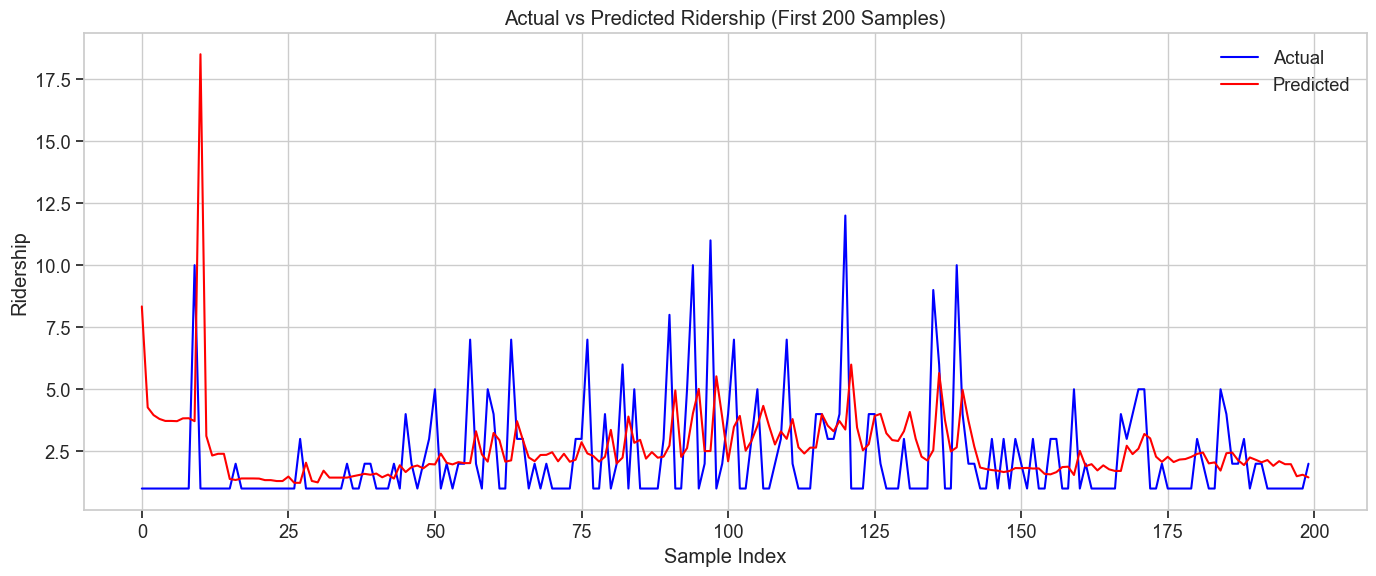

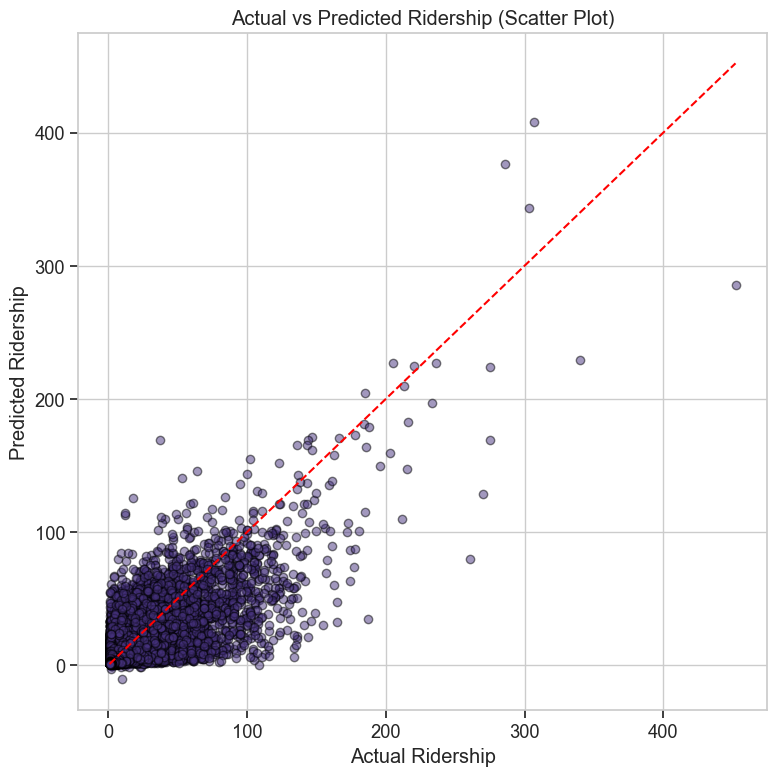

In [9]:
# Plot actual vs predicted
plt.figure(figsize=(14, 6))
plt.plot(y_true.values[:200], label='Actual', color='blue')
plt.plot(y_pred[:200], label='Predicted', color='red')
plt.title('Actual vs Predicted Ridership (First 200 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Ridership')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_true, y_pred, alpha=0.5, edgecolors='k')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  # Perfect prediction line
plt.xlabel('Actual Ridership')
plt.ylabel('Predicted Ridership')
plt.title('Actual vs Predicted Ridership (Scatter Plot)')
plt.grid(True)
plt.tight_layout()
plt.show()



## **Hyperparameter Tuning**

In [13]:
# Import required libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# First, let's create our feature matrix and target vector
X = train_df[available_features]  # Use the same features as our XGBoost model
y = train_df['target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the hyperparameter grid for Ridge regression
ridge_params = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}

# Now your Ridge regression code should work
ridge = Ridge()
ridge_cv = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train_scaled, y_train)

# Get best hyperparameters
best_ridge_alpha = ridge_cv.best_params_['alpha']

In [14]:
# Ensure train_df is defined and necessary libraries are imported
import pandas as pd
import numpy as np
import xgboost as xgb
from pathlib import Path
from sklearn.metrics import mean_squared_error

# Define paths if needed
if 'train_path' not in globals():
    DATA_DIR = Path('../data/processed')
    train_path = DATA_DIR / 'komuter_train.csv'

if 'train_df' not in globals():
    train_df = pd.read_csv(train_path)

# Split training into train/val for tuning
train_data = train_df.sample(frac=0.8, random_state=42)
val_data = train_df.drop(train_data.index)

dtrain = xgb.DMatrix(train_data[available_features], label=train_data['target'])
dval = xgb.DMatrix(val_data[available_features], label=val_data['target'])

def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'lambda': trial.suggest_float('lambda', 0.1, 5.0),  # L2
        'alpha': trial.suggest_float('alpha', 0.0, 5.0),    # L1
        'seed': 42
    }

    model = xgb.train(params, dtrain, num_boost_round=1000,
                      evals=[(dval, 'validation')],
                      early_stopping_rounds=30,
                      verbose_eval=False)

    preds = model.predict(dval)
    rmse = np.sqrt(mean_squared_error(val_data['target'], preds))
    return rmse

In [15]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)  # Try 50 different combinations

[I 2025-06-02 13:22:23,449] A new study created in memory with name: no-name-7506b71e-eca6-46d6-91f1-77b907b126a4
[I 2025-06-02 13:22:25,502] Trial 0 finished with value: 7.2065991869142705 and parameters: {'max_depth': 7, 'eta': 0.2195826470192225, 'subsample': 0.782420115690843, 'colsample_bytree': 0.6009209385504848, 'min_child_weight': 9, 'lambda': 2.7019847179381458, 'alpha': 4.318416535690427}. Best is trial 0 with value: 7.2065991869142705.
[I 2025-06-02 13:22:32,771] Trial 1 finished with value: 7.342495817989364 and parameters: {'max_depth': 3, 'eta': 0.03873963054066873, 'subsample': 0.8271768591902751, 'colsample_bytree': 0.9167265597352285, 'min_child_weight': 3, 'lambda': 1.386793042901127, 'alpha': 1.2626429769615177}. Best is trial 0 with value: 7.2065991869142705.
[I 2025-06-02 13:22:35,031] Trial 2 finished with value: 7.169099472660901 and parameters: {'max_depth': 9, 'eta': 0.22267431374455948, 'subsample': 0.8088212307500482, 'colsample_bytree': 0.7788147896058966, 

In [16]:
print("Best trial:")
print(f"  RMSE: {study.best_value:.4f}")
print("  Best hyperparameters:")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")

Best trial:
  RMSE: 7.1101
  Best hyperparameters:
    max_depth: 10
    eta: 0.012624753679677393
    subsample: 0.5630663962697493
    colsample_bytree: 0.6976743241448217
    min_child_weight: 9
    lambda: 0.9595631067076286
    alpha: 3.6284380656930346


In [17]:
best_params = study.best_params
best_params['objective'] = 'reg:squarederror'
best_params['eval_metric'] = 'rmse'

dtrain_full = xgb.DMatrix(train_df[available_features], label=train_df['target'])
dtest = xgb.DMatrix(test_df[available_features], label=test_df['target'])

model_optuna = xgb.train(best_params, dtrain_full, num_boost_round=1000,
                  evals=[(dtrain_full, 'train')],
                  early_stopping_rounds=30, verbose_eval=50)

[0]	train-rmse:11.30934
[50]	train-rmse:8.53265
[100]	train-rmse:7.32227
[150]	train-rmse:6.80174
[200]	train-rmse:6.55060
[250]	train-rmse:6.41206
[300]	train-rmse:6.31815
[350]	train-rmse:6.25236
[400]	train-rmse:6.20513
[450]	train-rmse:6.16701
[500]	train-rmse:6.13347
[550]	train-rmse:6.09809
[600]	train-rmse:6.07043
[650]	train-rmse:6.04456
[700]	train-rmse:6.01626
[750]	train-rmse:5.98802
[800]	train-rmse:5.96070
[850]	train-rmse:5.93584
[900]	train-rmse:5.91287
[950]	train-rmse:5.88827
[999]	train-rmse:5.86523


In [18]:
# Make predictions with your trained model
dtest = xgb.DMatrix(test_df[available_features])
preds = model_optuna.predict(dtest)

y_true = test_df['target']
y_pred = preds

# Metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Print results
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"R²:   {r2:.4f}")

MSE:  42.98
RMSE: 6.56
MAE:  2.96
R²:   0.5937


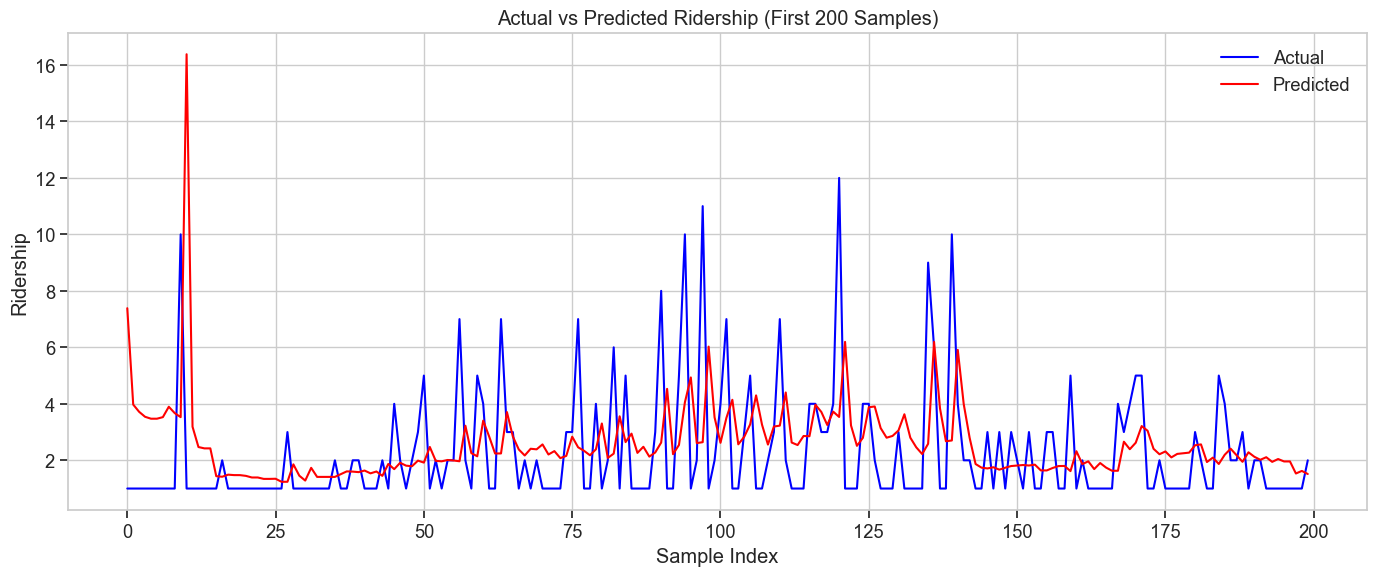

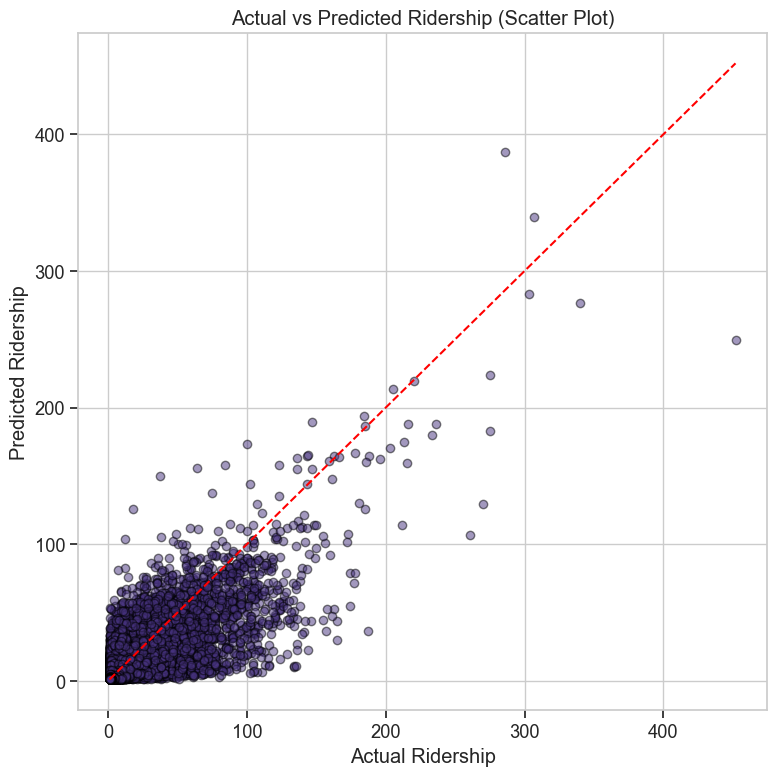

In [19]:
# Plot actual vs predicted
plt.figure(figsize=(14, 6))
plt.plot(y_true.values[:200], label='Actual', color='blue')
plt.plot(y_pred[:200], label='Predicted', color='red')
plt.title('Actual vs Predicted Ridership (First 200 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Ridership')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_true, y_pred, alpha=0.5, edgecolors='k')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  # Perfect prediction line
plt.xlabel('Actual Ridership')
plt.ylabel('Predicted Ridership')
plt.title('Actual vs Predicted Ridership (Scatter Plot)')
plt.grid(True)
plt.tight_layout()
plt.show()

## **Blend XGBoost, LightGBM, and RandomForest Predictions**

In [20]:
# Train each model
# 1. XGBoost
dtrain = xgb.DMatrix(train_df[available_features], label=train_df['target'])
dtest = xgb.DMatrix(test_df[available_features])

xgb_model = xgb.train(best_params, dtrain, num_boost_round=300)
xgb_preds = xgb_model.predict(dtest)

# 2. LightGBM
lgb_model = lgb.LGBMRegressor(**{
    'n_estimators': 300,
    'learning_rate': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42
})
lgb_model.fit(train_df[available_features], train_df['target'])
lgb_preds = lgb_model.predict(test_df[available_features])

# 3. RandomForest
rf_model = RandomForestRegressor(
    n_estimators=300, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(train_df[available_features], train_df['target'])
rf_preds = rf_model.predict(test_df[available_features])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3948
[LightGBM] [Info] Number of data points in the train set: 534412, number of used features: 18
[LightGBM] [Info] Start training from score 4.834783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

In [21]:
# Blend predictions
ensemble_preds = (xgb_preds + lgb_preds + rf_preds) / 3

In [22]:
y_true = test_df['target']
mse = mean_squared_error(y_true, ensemble_preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, ensemble_preds)
r2 = r2_score(y_true, ensemble_preds)

print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"R²:   {r2:.4f}")

MSE:  42.95
RMSE: 6.55
MAE:  2.97
R²:   0.5940


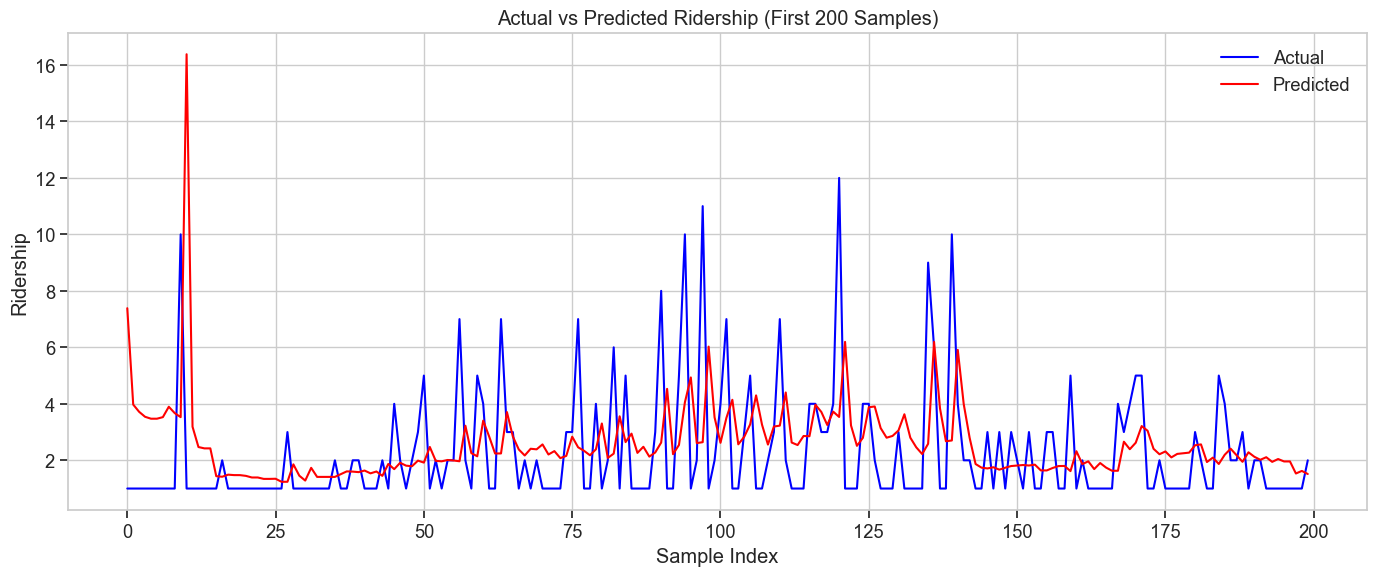

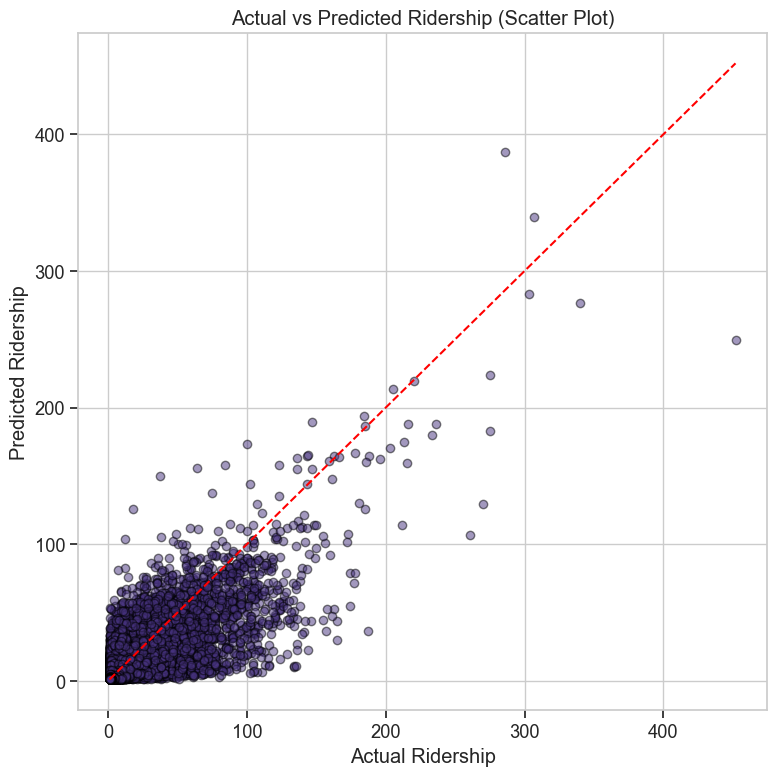

In [23]:
# Visualize predictions vs actual values
# Plot actual vs predicted
plt.figure(figsize=(14, 6))
plt.plot(y_true.values[:200], label='Actual', color='blue')
plt.plot(y_pred[:200], label='Predicted', color='red')
plt.title('Actual vs Predicted Ridership (First 200 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Ridership')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_true, y_pred, alpha=0.5, edgecolors='k')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  # Perfect prediction line
plt.xlabel('Actual Ridership')
plt.ylabel('Predicted Ridership')
plt.title('Actual vs Predicted Ridership (Scatter Plot)')
plt.grid(True)
plt.tight_layout()
plt.show()

## **Model Saving**

Now that we've trained our models, let's save them for later use. We'll save:
1. The XGBoost model in both pickle and JSON formats
2. The LightGBM model
3. The Random Forest model
4. The feature scaling information
5. Performance metrics

In [24]:
# Create models directory if it doesn't exist
model_dir = Path('../models')
model_dir.mkdir(exist_ok=True)

# 1. Save the XGBoost model (pickle format - Python specific)
xgb_model_path = model_dir / 'xgboost_model.pkl'
joblib.dump(xgb_model, xgb_model_path)
print(f"✅ XGBoost model saved to {xgb_model_path}")

# 2. Save XGBoost model in JSON format (more portable)
xgb_json_path = model_dir / 'xgboost_model.json'
xgb_model.save_model(xgb_json_path)
print(f"✅ XGBoost model saved in JSON format to {xgb_json_path}")

# 3. Save LightGBM model
lgb_model_path = model_dir / 'lgb_model.pkl'
joblib.dump(lgb_model, lgb_model_path)
print(f"✅ LightGBM model saved to {lgb_model_path}")

# 4. Save Random Forest model
rf_model_path = model_dir / 'rf_model.pkl'
joblib.dump(rf_model, rf_model_path)
print(f"✅ Random Forest model saved to {rf_model_path}")

# 5. Save model evaluation results
eval_results = {
    'mse': mse,
    'rmse': rmse,
    'mae': mae,
    'r2': r2,
    'best_params': best_params
}

eval_path = model_dir / 'xgboost_evaluation.pkl'
joblib.dump(eval_results, eval_path)
print(f"✅ Model evaluation metrics saved to {eval_path}")

# Example of how to load and use the model
print("\nExample code to load and use the model:")
print("""
# Load XGBoost model (Option 1: from pickle)
xgb_model = joblib.load('models/xgboost_model.pkl')
# OR
# Load XGBoost model (Option 2: from JSON - more portable)
xgb_model = xgb.Booster()
xgb_model.load_model('models/xgboost_model.json')

# Load required features
features = joblib.load('models/xgboost_features.pkl')

# Prepare your data
new_data = pd.DataFrame(...)  # Your new data
dpredict = xgb.DMatrix(new_data[features])

# Make predictions
predictions = xgb_model.predict(dpredict)
""")

✅ XGBoost model saved to ..\models\xgboost_model.pkl
✅ XGBoost model saved in JSON format to ..\models\xgboost_model.json
✅ LightGBM model saved to ..\models\lgb_model.pkl
✅ Random Forest model saved to ..\models\rf_model.pkl
✅ Model evaluation metrics saved to ..\models\xgboost_evaluation.pkl

Example code to load and use the model:

# Load XGBoost model (Option 1: from pickle)
xgb_model = joblib.load('models/xgboost_model.pkl')
# OR
# Load XGBoost model (Option 2: from JSON - more portable)
xgb_model = xgb.Booster()
xgb_model.load_model('models/xgboost_model.json')

# Load required features
features = joblib.load('models/xgboost_features.pkl')

# Prepare your data
new_data = pd.DataFrame(...)  # Your new data
dpredict = xgb.DMatrix(new_data[features])

# Make predictions
predictions = xgb_model.predict(dpredict)

